In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

# 1. Exploratory Data Analysis (EDA)

In [2]:
# deading data
df = pd.read_csv('hotel_bookings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119210 non-null  int64  
 1   lead_time                       119210 non-null  int64  
 2   arrival_date_week_number        119210 non-null  int64  
 3   arrival_date_day_of_month       119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119206 non-null  float64
 9   babies                          119210 non-null  int64  
 10  is_repeated_guest               119210 non-null  int64  
 11  previous_cancellations          119210 non-null  int64  
 12  previous_booking

In [3]:
# Lets's create a complementary dataset to work on
data = df.copy()
data.head(10)

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,avg_daily_rate,booked_by_company,booked_by_agent,hotel_City,hotel_Resort,meal_BB,meal_FB,meal_HB,meal_No_meal,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline_TA_TO,market_segment_Online_TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA_TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,27,1,7,0,0,2,0.0,0,0,0,0,0,0,0.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,737,27,1,7,0,0,2,0.0,0,0,0,0,0,0,0.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,7,27,1,7,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,13,27,1,7,0,1,1,0.0,0,0,0,0,0,0,75.0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,14,27,1,7,0,2,2,0.0,0,0,0,0,0,1,98.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,0,14,27,1,7,0,2,2,0.0,0,0,0,0,0,1,98.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,0,0,27,1,7,0,2,2,0.0,0,0,0,0,0,0,107.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,0,9,27,1,7,0,2,2,0.0,0,0,0,0,0,1,103.0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
8,1,85,27,1,7,0,3,2,0.0,0,0,0,0,0,1,82.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
9,1,75,27,1,7,0,3,2,0.0,0,0,0,0,0,0,105.5,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0


# * Observation
The dataFrame has a total of 52 feature variables plus a column called `is_canceled` which is the variable to predict. Some feature variables encoded as numerical variables whereas others are of binary type. Recall that this dataset was cleaned in advance where some features were onehot encoded.

Now we'll explore the distribution of some numerical variables. Let's examine `lead_time` and `avg_daily_rate` 

2022-05-11 22:14:40.284514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 22:14:40.284562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Average daily rate outlier : 48491    5400.0
Name: avg_daily_rate, dtype: float64



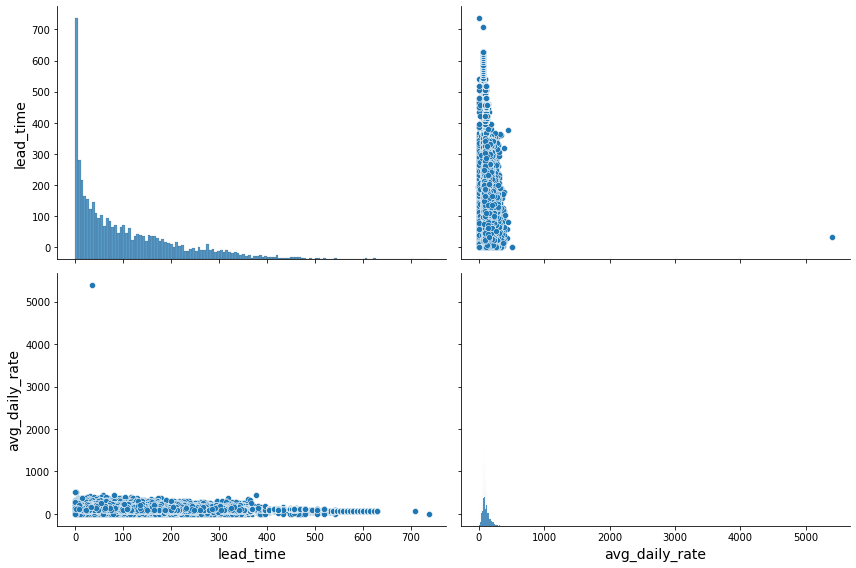

In [4]:
from utils import pairplot_check # import function

l_time = data['lead_time']

adr = data['avg_daily_rate']
adr_filt = data['avg_daily_rate']>1000
print (f'Average daily rate outlier : {adr[adr_filt]}')
print()


frame = pd.concat([l_time, adr], axis=1)

# plot the selected data on 'frame'
pairplot_check(frame) 

# * Observation
As we can see, the lead time behaves as a continuous variable and there is no outlier to account for. However, there is a huge outlier on `average_daily_rate` variable, which indeed needs to be imputed before to proceed. 
Because it is a single value we will remove that entry directly from the dataset.

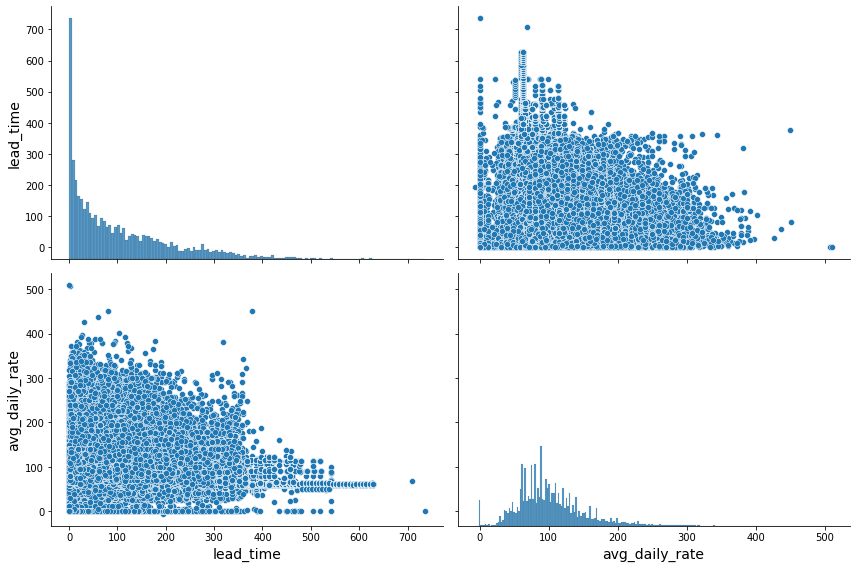

In [5]:
data.drop(48491, axis=0, inplace=True)
adr = data['avg_daily_rate']

# Sanity check
imputed_frame = pd.concat([l_time, adr], axis=1)
# plot the selected data on 'imputed_frame'
pairplot_check(imputed_frame)

# Missing values

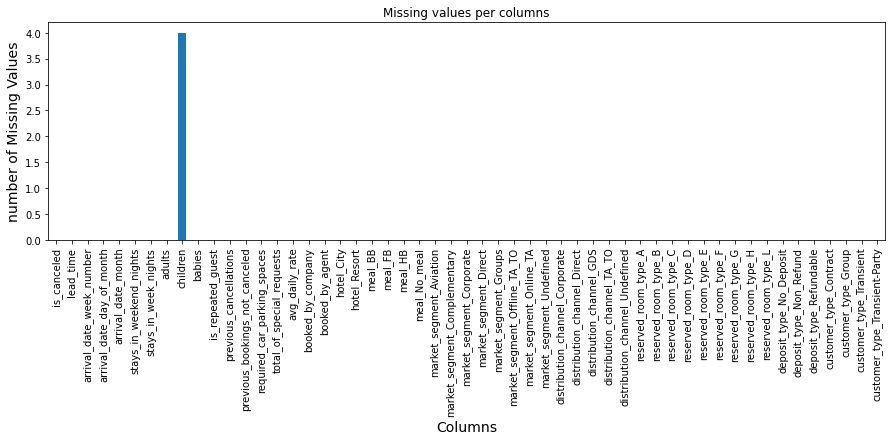

In [6]:
data.isnull().sum().plot(kind = 'bar', figsize = (15,4))
plt.title('Missing values per columns')
plt.xlabel('Columns', size=14)
plt.ylabel('number of Missing Values', size=14)
plt.show()

# * Observation
There are four missing values on column `children`. Lest proceed to impute these values by filling with the mean of the full column

In [7]:
# Impute missing values on children variable
print('Number of missing values before imputation: ', data['children'].isnull().sum())
data['children'] = data['children'].fillna(data['children'].mean())
data['children'] = data['children'].astype(int)

print('Number of missing values upon imputation:   ', data['children'].isnull().sum())

Number of missing values before imputation:  4
Number of missing values upon imputation:    0


# How does the number of reservations and cancelations behaves along the year?


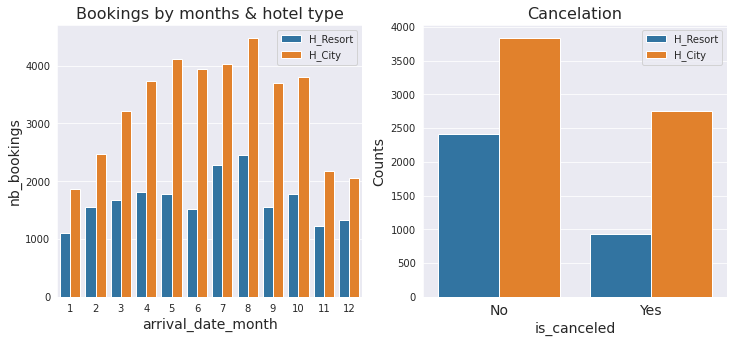

In [8]:
# Prepare data for plotting
bookings_by_month = pd.DataFrame(data.groupby(['arrival_date_month', 'is_canceled', 'hotel_City'])[['is_canceled']].count())
bookings_by_month =bookings_by_month.rename(columns={'is_canceled': 'Counts'}).reset_index()

# Create some variables only for visualization pupose.
hotel_type = bookings_by_month['hotel_City'].map({0: 'H_Resort', 1: 'H_City'})
cancelation = bookings_by_month['is_canceled'].map({0: 'No', 1: 'Yes'})

# Plotting data
sns.set_style('darkgrid')
fig, axs = plt.subplots(1,2, figsize=(12, 5))
sns.barplot(ax=axs[0], data = bookings_by_month, x='arrival_date_month',  y='Counts', hue=hotel_type, ci=None)
axs[0].set_title('Bookings by months & hotel type', size=16)
axs[0].set_xlabel('arrival_date_month', size=14)
axs[0].set_ylabel('nb_bookings',size=14)
axs[0].legend().set_title('')

sns.barplot(ax=axs[1],  x=bookings_by_month.is_canceled, y=bookings_by_month.Counts, hue=hotel_type, ci=None)
axs[1].set_title('Cancelation', size=16)
axs[1].set_xticklabels(['No', 'Yes'], size=14)
axs[1].set_ylabel('Counts',size=14)
axs[1].set_xlabel('is_canceled', size=14)
axs[1].legend().set_title('')

plt.show()


# * Observation
According to the left plot it can be noticed that, for this dataset, people are more enthusiastic for going to City Hotels rather than to Resort Hotels. According to the very right plot, it seems to be more cancellations on City hotels. However, this should be taken with caution due to the fact that City hotels exhibits more reservation as well

# Is booking cancelation influenced by family size?

Now let's check whether family size is associated with booking cancellation. To do that it is necessary to create an additional variable to account for family size according to the variables `adults`, `children` and `babies`. In addition, we will create an additional variable to split `family_size` variable into two categories (e.g. 1 for a "normal" family (up to three members) and 2 for a large family (more than 3 members).

In [9]:
# Create a categorical family_size column
data['family_size'] = data.loc[:, ['adults', 'children', 'babies']].sum(axis=1)
data['family_size_cat'] = [1 if val <= 3 else 2 for val in data['family_size']]

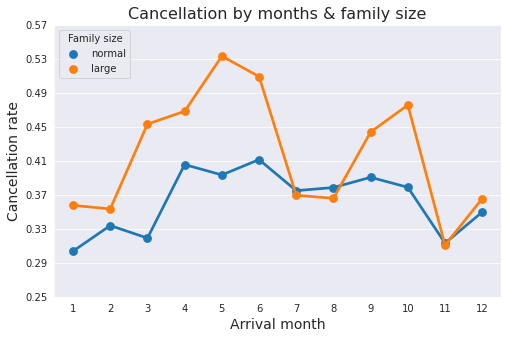

In [10]:
# To account for the number of bookings
cols=['arrival_date_month', 'family_size_cat', 'is_canceled']
nb_booking = pd.DataFrame(data.groupby(['arrival_date_month', 'family_size_cat'])['is_canceled'].count())
nb_booking = nb_booking.rename(columns={'is_canceled': 'nb_booking'}).reset_index()

# Select only canceled reservations
canceled_data = data[data['is_canceled'] == 1][cols]

# Create a complementary dataset for family size analysis
fs_data = pd.DataFrame(canceled_data.groupby(['arrival_date_month', 'family_size_cat'])['is_canceled'].count())
fs_data = fs_data.rename(columns={'is_canceled': 'Cancellation_counts'}).reset_index()
fam_cat = fs_data['family_size_cat'].map({1: 'normal', 2: 'large'})

# Compute the cancelation rate
fs_data = fs_data.merge(nb_booking, on = ['arrival_date_month', 'family_size_cat'])
fs_data['cancelation_rate'] = fs_data.Cancellation_counts/fs_data.nb_booking

# Plotting data
fig, ax = plt.subplots(figsize=(8,5))
sns.pointplot(ax=ax, data = fs_data, x='arrival_date_month', y = 'cancelation_rate', hue = fam_cat)
plt.title('Cancellation by months & family size', size=16)
plt.xlabel('Arrival month', size=14)
plt.yticks(np.arange(0.25, 0.6, 0.04))
plt.ylabel('Cancellation rate',size=14)
plt.legend(loc='upper left').set_title('Family size')

plt.show()


# * Observation
The plot suggests that large families are, in general, more probable to cancel the reservation, whereas an average family are less prompt to cancel. Interestingly, in summer seasonn (July - August) large families ehibits a cancellation probability decrease, towards simmilar values as the normal sized families.

# 2. Prepare data for fitting

In this step we will prepare data for fitting. The following function, splitt data into categorical and numerical variables. Optionally it also performs normalization on numerical data. To train the model on a portion of the data and test its performance on the other portion that has not been seen by the model we will divide the data into X_train, X_test, y_train and y_test for training and testing. In addition, we will rename some columns from the dataset to have shorter names. This is useful mainly for data visualization.

In [11]:
from utils import parse_data
cols_to_skip =['adults', 'children', 'babies', 'family_size_cat']

X_train, X_test, y_train, y_test = parse_data(data, skip_cols=True, col_list=cols_to_skip, normalize_data=False)
display (X_train.var())

lead_time                         11377.422576
ad_week_number                      185.379958
ad_day_of_month                      77.090902
ad_month                              9.564385
nb_weekend_nights                     0.990799
nb_week_nights                        3.606057
prev_cancellations                    0.702535
prev_b_not_canceled                   2.247928
parking                               0.059333
special_requests                      0.629637
avg_daily_rate                     2298.353235
family_size                           0.535992
is_repeated_guest                     0.030704
booked_by_company                     0.053173
booked_by_agent                       0.117883
hotel_City                            0.222483
hotel_Resort                          0.222483
meal_BB                               0.174776
meal_FB                               0.006536
meal_HB                               0.106488
meal_No_meal                          0.088381
market_segmen

# 3. Model definition
Now we will use three ensemble-based models to fit the data but using default hyperparameters. The ideas is to select the best scored model to which perform hyperparameter tuning later. Let's make the test on Random Forest, Adaboost and Gradientboosting classification models. We will use scikit-learn to fit the models through a cross validation method to find the best model for the analysis.

In [12]:
# Split the data cross validation
SEED=42
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#Instantiate models to test
models = [
    ('rfc', RandomForestClassifier(random_state=SEED)),
    ('abc', AdaBoostClassifier(random_state=SEED)),
    ('gbc', GradientBoostingClassifier(random_state=SEED))
]


# 4. Fit the models and evaluate their performances

Les's test the selected models on the data without normalization. In addition we will use 5-fold crossvalidation to get the average score from each model 

In [13]:
from utils import model_fit
# Determine the best model by comparing the crossvalidation scores
for name, model in models:
    mean_score, std_dev, min_score, max_score = model_fit(model, X_train,y_train, X_test, y_test, cross_validate=True, cv_splits=5)
    print(f'[{name}] Accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}')

[rfc] Accuracy score: 0.8579 +/- 0.0011 (std) min: 0.8569, max: 0.8594
[abc] Accuracy score: 0.8147 +/- 0.002 (std) min: 0.8125, max: 0.8179
[gbc] Accuracy score: 0.8156 +/- 0.0011 (std) min: 0.8144, max: 0.817


Now with the normalized data

In [14]:
X_train, X_test, y_train, y_test = parse_data(data, skip_cols=True, col_list=cols_to_skip, normalize_data=True)
display (X_train.var())

# Determine the best model by comparing the crossvalidation scores
for name, model in models:
    mean_score, std_dev, min_score, max_score = model_fit(model, X_train,y_train, X_test, y_test, cross_validate=True, cv_splits=5)
    print(f'[{name}] Accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}')

lead_time                         2.581365
ad_week_number                    0.442365
ad_day_of_month                   0.505121
avg_daily_rate                    0.515986
ad_month                          9.564385
nb_weekend_nights                 0.990799
nb_week_nights                    3.606057
prev_cancellations                0.702535
prev_b_not_canceled               2.247928
parking                           0.059333
special_requests                  0.629637
family_size                       0.535992
is_repeated_guest                 0.030704
booked_by_company                 0.053173
booked_by_agent                   0.117883
hotel_City                        0.222483
hotel_Resort                      0.222483
meal_BB                           0.174776
meal_FB                           0.006536
meal_HB                           0.106488
meal_No_meal                      0.088381
market_segment_Aviation           0.001938
market_segment_Complementary      0.006157
market_segm

[rfc] Accuracy score: 0.8583 +/- 0.0016 (std) min: 0.856, max: 0.86
[abc] Accuracy score: 0.8147 +/- 0.002 (std) min: 0.8125, max: 0.8179
[gbc] Accuracy score: 0.8156 +/- 0.0011 (std) min: 0.8144, max: 0.8169


# * Observation
There is not much difference among scores from the tested models, must probable because we are testing ensemble-based models. However, because we are also interested to test a Keras model we will proceed with the normalized dataset.   

# 5. Hyperparameter tuning
As per the cross validation score, the Random Forest Classifier model has a better performance, at least during the training step. But how does the model behave on predicting unseen data. To do that we will do hyperparameter tuning on this model to have a better performance. Because of a lack of computational power, we are going to focus only in on `n_estimators`. However, other parameters like `max_depth`, `min_samples_leaf`, `bootstrap` and `criterion` could be optimized as well. Because only one parameter is going to be optimized we won't use GridSearch but a simple iteration.

n_estimators: [100]     prediction score: 0.8588485306042558
n_estimators: [200]     prediction score: 0.8592959203646227
n_estimators: [300]     prediction score: 0.8605262422056316
n_estimators: [400]     prediction score: 0.8609736319659984
n_estimators: [500]     prediction score: 0.860721975225792
n_estimators: [600]     prediction score: 0.8608338226658837
n_estimators: [700]     prediction score: 0.8608897463859296
n_estimators: [800]     prediction score: 0.8604423566255628
n_estimators: [900]     prediction score: 0.8601627380253335
n_estimators: [1000]     prediction score: 0.8605542040656544

 Best number of estimators: 400 with a score: 0.8609736319659984



[]

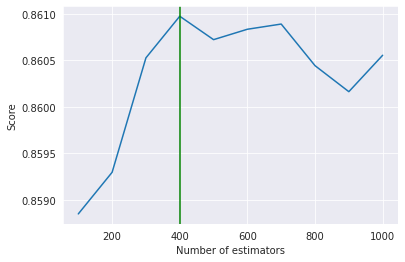

In [15]:
# Tune n_estimators
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
scores = []
    
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=42)

    pred_score, label_predict = model_fit(model, X_train, y_train, X_test, y_test)
    scores.append(pred_score)
        
    print(f"n_estimators: [{n}]     prediction score: {pred_score}")
    
largest_score = scores[0]
for i, val in enumerate(scores):
    if val > largest_score:
        largest_score = val
        best_param = n_estimators[i]

print()
print (f' Best number of estimators: {best_param} with a score: {largest_score}')
print()
    

# Plotting scores
fig = sns.lineplot(x=n_estimators, y=scores)
plt.axvline(x=best_param, color='g', label='best parameter')
fig.set_xlabel('Number of estimators')
fig.set_ylabel('Score')
plt.plot()

# * Observation
According to the plot, the best parameter is 400, although 700 could also be a good decision. We are going to use 400 to proceed. In addition we will have a look to the feature_importances atribute from the fitted model. This can be used to reduce the number of features which and can simplify the model, speed up the modeling process because of the dimensionality reduction, and in some cases, improve the performance of the model.

Accuracy Score rfc:  0.8609736319659984

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89     22503
           1       0.86      0.75      0.80     13260

    accuracy                           0.86     35763
   macro avg       0.86      0.84      0.85     35763
weighted avg       0.86      0.86      0.86     35763



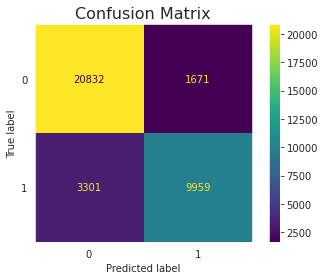

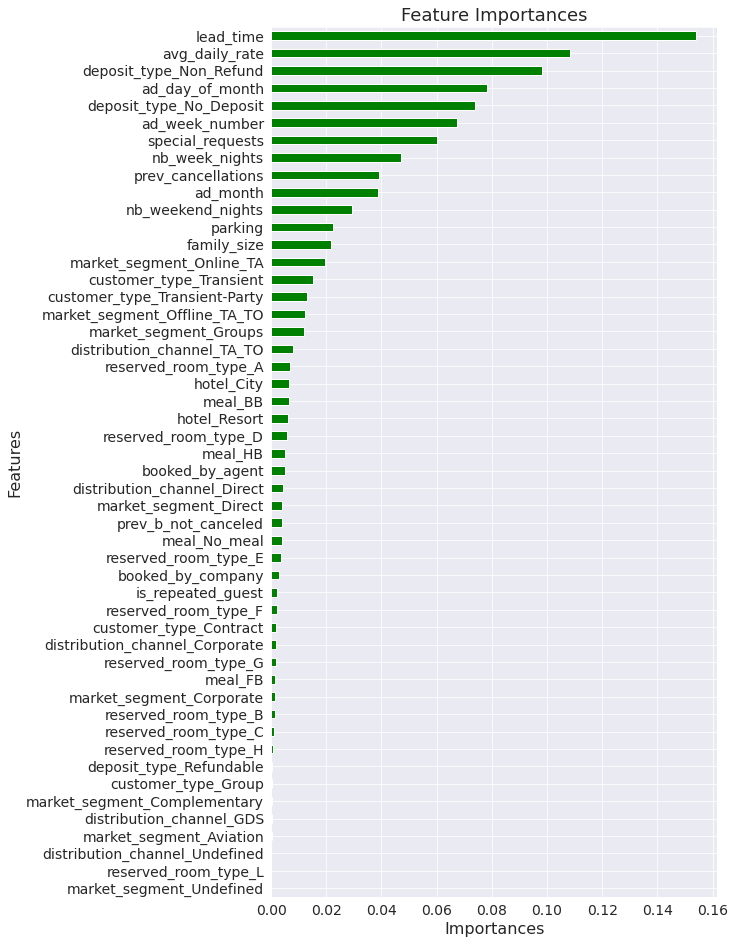

In [16]:
from utils import make_prediction
model = RandomForestClassifier(n_estimators=400, random_state=42)
make_prediction(model, X_train, y_train, X_test, y_test)

# Keras model

Lets's test now how does a simple keras-based bodel fits our data. 

2022-05-10 21:43:17.324184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 21:43:17.324231: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 21:43:17.324271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc-yunior): /proc/driver/nvidia/version does not exist


Epoch 1/80
8345/8345 [==============================] - 35s 4ms/step - loss: 0.4352 - accuracy: 0.8001 - val_loss: 0.4128 - val_accuracy: 0.8136
Epoch 2/80
8345/8345 [==============================] - 32s 4ms/step - loss: 0.4075 - accuracy: 0.8117 - val_loss: 0.4003 - val_accuracy: 0.8117
Epoch 3/80
8345/8345 [==============================] - 32s 4ms/step - loss: 0.4025 - accuracy: 0.8129 - val_loss: 0.3949 - val_accuracy: 0.8150
Epoch 4/80
8345/8345 [==============================] - 33s 4ms/step - loss: 0.3992 - accuracy: 0.8136 - val_loss: 0.3949 - val_accuracy: 0.8136
Epoch 5/80
8345/8345 [==============================] - 33s 4ms/step - loss: 0.3976 - accuracy: 0.8143 - val_loss: 0.3916 - val_accuracy: 0.8139
Epoch 6/80
8345/8345 [==============================] - 33s 4ms/step - loss: 0.3959 - accuracy: 0.8150 - val_loss: 0.3988 - val_accuracy: 0.8149
Epoch 7/80
8345/8345 [==============================] - 33s 4ms/step - loss: 0.3944 - accuracy: 0.8160 - val_loss: 0.3916 - val_ac

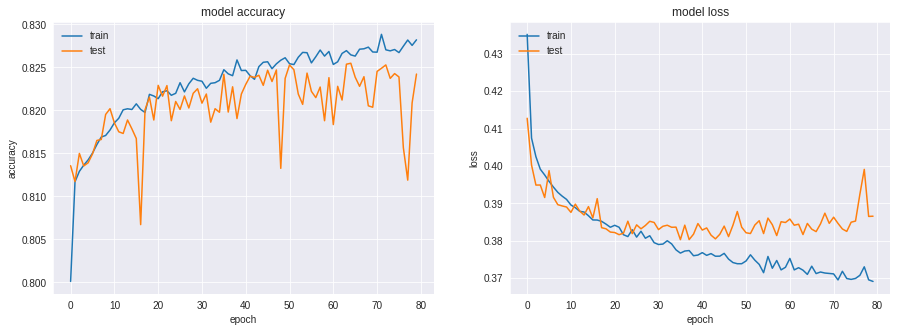

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from utils import create_basemodel

# create dummie subsets from labels 
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

d_shape=X_train.shape[1]

# evaluate baseline model with standardized dataset
model = create_basemodel(d_shape)

# Fit the model
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=80, batch_size=10, verbose=1)
print(history.history.keys())

# Plotting history
fig, axs = plt.subplots(1,2, figsize=(15, 5))
plt.style.use('seaborn-whitegrid')

# accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

# loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')
plt.show()